In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import healpy as hp
from healpy.newvisufunc import projview
import itertools as it
import fitsio
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u
import time
import os
import sys
sys.path.insert(0, '/work2/08811/aew492/frontera/lss-dipoles')
import tools
from qso_sample import QSOSample
import dipole
import ellisbaldwin
import multipoles
from jackknife import get_longitude_subsamples_from_hpmap, compute_jackknife_uncertainty, covar_jackknife

## CatWISE

### without / with selection function

In [3]:
# Wmask for regularization
Wmask = 0.1

In [4]:
# instantiate dipole object:
d = QSOSample(initial_catfn='catwise_agns_master.fits', catname='catwise_agns', mag='w1',
                    blim=30, maglim=16.4, load_init=True)
d.cut_galactic_plane()

# get expected dipole amplitude
expected_dipamp = ellisbaldwin.compute_expected_dipole_wise(d.table, maglimit=d.maglim,
                                                            min_w1=16., max_w1=16.5)
d.cut_mag()

# and delete initial table to clear memory
del d.initial_cattab

# explicitly set the selection function:
#  'None' assumes completeness = 1 everywhere
d.set_selfunc('None')

# finally, construct the overdensity map
overdensity_map = d.construct_overdensity_map()

# and save the masked data map (to correct for density wrt ecliptic latitude, below)
masked_datamap = d.masked_datamap

# and measure the dipole
comps = d.measure_dipole_in_overdensity_map(overdensity_map, Wmask=Wmask)
dipole.get_dipole(comps)

loading initial catalog, catwise_agns_master.fits
8532854 sources in initial catalog.
cut |b| <= 30 -> 4479160 sources left.
number-count slope x = 1.748
effective alpha = 1.270
expected dipole amplitude = 0.0074
cut w1 > 16.4 -> 1400045 sources left.
constructing overdensity map...
defining healpix mask...
	masked pixels |b|<30deg, from mask_fn, and where completeness < 0.5


(0.01476468981404431,
 <SkyCoord (ICRS): (ra, dec) in deg
     (143.02392079, -14.34510814)>)

In [5]:
# WITH selection function
d.set_selfunc(os.path.join(d.catdir, 'selfuncs/selection_function_NSIDE64_catwise_pluszodis.fits'))
overdensity_map_sf = d.construct_overdensity_map()
masked_datamap_sf = d.masked_datamap
comps_sf = d.measure_dipole_in_overdensity_map(overdensity_map_sf, Wmask=Wmask)
dipole.get_dipole(comps_sf)

constructing overdensity map...
defining healpix mask...
	masked pixels |b|<30deg, from mask_fn, and where completeness < 0.5


(0.010564326977796112,
 <SkyCoord (ICRS): (ra, dec) in deg
     (135.69815179, 28.35964193)>)

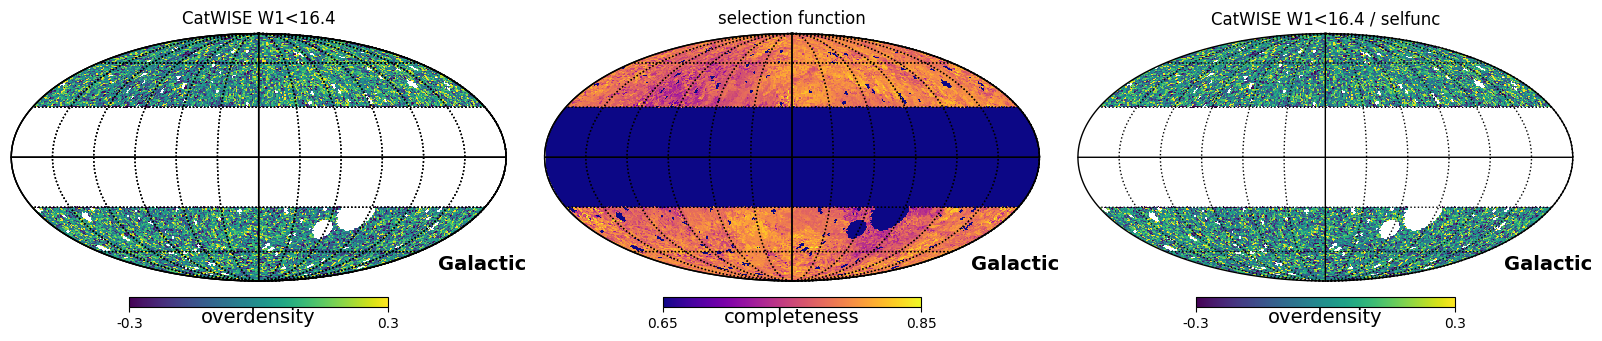

In [6]:
# plot to compare
fig = plt.figure(figsize=(16,3))
hp.mollview(overdensity_map, coord=['C','G'], min=-0.3, max=0.3, badcolor='w', fig=fig, sub=(1,3,1),
            unit='overdensity', title=f'CatWISE W1<{d.maglim}')
hp.graticule()
hp.mollview(d.selfunc, coord=['C','G'], min=0.65, max=0.85, badcolor='w', fig=fig, sub=(1,3,2), cmap='plasma',
            unit='completeness', title=f'selection function')
hp.graticule()
hp.mollview(overdensity_map_sf, coord=['C','G'], min=-0.3, max=0.3, badcolor='w', fig=fig, sub=(1,3,3),
            unit='overdensity', title=f'CatWISE W1<{d.maglim} / selfunc')
hp.graticule()

In [7]:
# Cells measurement
max_ell = 8
ells, Cells = multipoles.compute_Cells_in_overdensity_map(overdensity_map,
                                                          Wmask=Wmask, max_ell=max_ell, selfunc=None)
ells, Cells_sf = multipoles.compute_Cells_in_overdensity_map(overdensity_map_sf,
                                                          Wmask=Wmask, max_ell=max_ell, selfunc=d.selfunc)

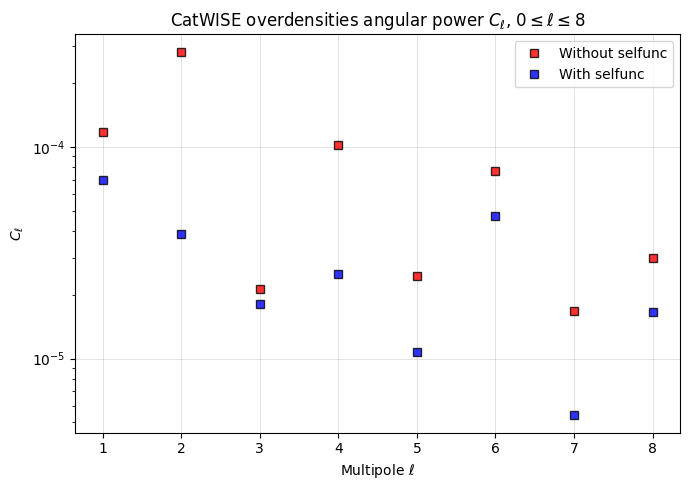

In [8]:
# plottt
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)
kwargs = dict(ls='None', mec='k', ms=6, marker='s')
ax.plot(ells[1:], Cells[1:], label='Without selfunc', c='r', alpha=0.8, **kwargs)
ax.plot(ells[1:], Cells_sf[1:], label='With selfunc', c='b', alpha=0.8, **kwargs)

ax.semilogy()
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'Multipole $\ell$')
ax.set_xticks(ells[1:])
ax.set_ylabel(r'$C_\ell$')
ax.set_title(r'CatWISE overdensities angular power $C_\ell$, $0\leq\ell\leq$'f'{max_ell}')
ax.legend()

### without / with ecliptic latitude correction

In [9]:
# ecliptic latitudes of each HEALPIXEL
lon, lat = hp.pix2ang(d.NSIDE, np.arange(hp.nside2npix(d.NSIDE)), lonlat=True)
elat = SkyCoord(lon * u.deg, lat * u.deg, frame='icrs').geocentrictrueecliptic.lat

# fit a line: density vs elat
idx = ~np.isnan(elat) & ~np.isnan(masked_datamap)
p = np.polyfit(np.abs(elat)[idx], masked_datamap[idx], deg=1)
# correct the densities and fit to the corrected densities
map_elatcorr = masked_datamap - np.polyval(p, np.abs(elat.value)) + p[1]
p_corr = np.polyfit(np.abs(elat)[idx], map_elatcorr[idx], deg=1)
# then the overdensity map is
overdensity_map_elat = map_elatcorr / np.nanmean(map_elatcorr) - 1

# same for the completeness-corrected map
idx = ~np.isnan(elat) & ~np.isnan(masked_datamap_sf)
p_sf = np.polyfit(np.abs(elat)[idx], masked_datamap_sf[idx], deg=1)
map_elatcorr_sf = masked_datamap_sf - np.polyval(p_sf, np.abs(elat.value)) + p_sf[1]
p_corr_sf = np.polyfit(np.abs(elat)[idx], map_elatcorr_sf[idx], deg=1)
# then the overdensity map is
overdensity_map_sf_elat = map_elatcorr_sf / np.nanmean(map_elatcorr_sf) - 1

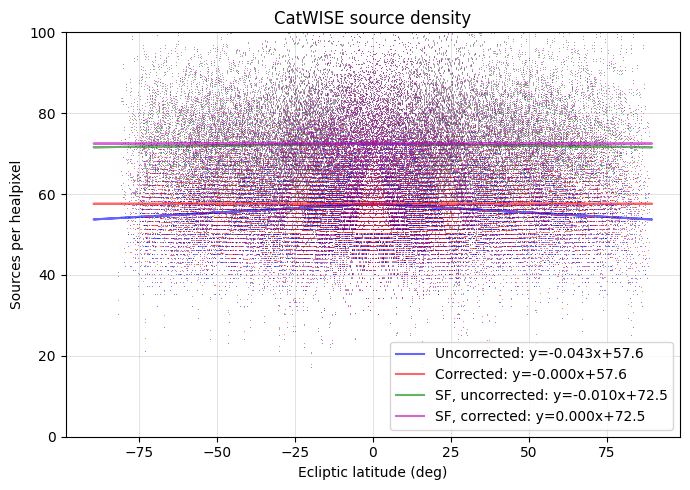

In [10]:
# plot before/after the correction
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)
# with no selection function:
# uncorrected
ax.plot(elat, masked_datamap, ls='None', marker=',', c='b', alpha=0.5)
# above the plane
ax.plot(elat[elat.value>0], elat.value[elat.value>0] * p[0] + p[1], c='b',
        alpha=0.6, label=f'Uncorrected: y={p[0]:.3f}x+{p[1]:.1f}')
# below the plane
ax.plot(elat[elat.value<0], - elat.value[elat.value<0] * p[0] + p[1], c='b', alpha=0.6)
# corrected
ax.plot(elat, map_elatcorr, ls='None', marker=',', c='r', alpha=0.5)
# above the plane
ax.plot(elat[elat.value>0], elat.value[elat.value>0] * p_corr[0] + p_corr[1], c='r',
        alpha=0.6, label=f'Corrected: y={p_corr[0]:.3f}x+{p_corr[1]:.1f}')
# below the plane
ax.plot(elat[elat.value<0], - elat.value[elat.value<0] * p_corr[0] + p_corr[1], c='r', alpha=0.6)

# with selection function:
# uncorrected
ax.plot(elat, masked_datamap_sf, ls='None', marker=',', c='g', alpha=0.5)
# above the plane
ax.plot(elat[elat.value>0], elat.value[elat.value>0] * p_sf[0] + p_sf[1], c='g',
        alpha=0.6, label=f'SF, uncorrected: y={p_sf[0]:.3f}x+{p_sf[1]:.1f}')
# below the plane
ax.plot(elat[elat.value<0], - elat.value[elat.value<0] * p_sf[0] + p_sf[1], c='g', alpha=0.6)
# corrected
ax.plot(elat, map_elatcorr_sf, ls='None', marker=',', c='m', alpha=0.5)
# above the plane
ax.plot(elat[elat.value>0], elat.value[elat.value>0] * p_corr_sf[0] + p_corr_sf[1], c='m',
        alpha=0.6, label=f'SF, corrected: y={p_corr_sf[0]:.3f}x+{p_corr_sf[1]:.1f}')
# below the plane
ax.plot(elat[elat.value<0], - elat.value[elat.value<0] * p_corr_sf[0] + p_corr_sf[1], c='m', alpha=0.6)

ax.grid(alpha=0.5, lw=0.5)
ax.set_ylim(0, 100)
ax.set_xlabel('Ecliptic latitude (deg)')
ax.set_ylabel('Sources per healpixel')
ax.set_title('CatWISE source density')
ax.legend()

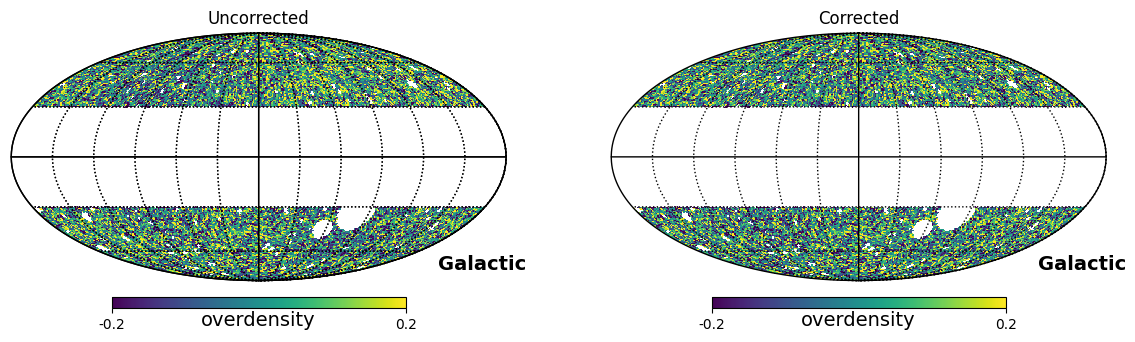

In [11]:
# check overdensity maps before and after
fig = plt.figure(figsize=(12,3))
kwargs = dict(coord=['C','G'], fig=fig, unit='overdensity', min=-.2, max=.2, badcolor='w')
hp.mollview(overdensity_map, sub=(1,2,1), title='Uncorrected', **kwargs)
hp.graticule()
hp.mollview(overdensity_map_elat, sub=(1,2,2), title='Corrected', **kwargs)
hp.graticule()

In [12]:
# measure dipole
comps_elat = d.measure_dipole_in_overdensity_map(overdensity_map_elat, Wmask=Wmask, selfunc='None')
print(dipole.get_dipole(comps_elat))
# and with selection function
comps_sf_elat = d.measure_dipole_in_overdensity_map(overdensity_map_sf_elat, Wmask=Wmask, selfunc=d.selfunc)
print(dipole.get_dipole(comps_sf_elat))

(0.013377551558305025, <SkyCoord (ICRS): (ra, dec) in deg
    (143.33249994, -5.65557859)>)
(0.010616387992418565, <SkyCoord (ICRS): (ra, dec) in deg
    (135.60760971, 30.54719819)>)


In [13]:
# measure Cells
ells, Cells_elat = multipoles.compute_Cells_in_overdensity_map(overdensity_map_elat,
                                                          Wmask=Wmask, max_ell=max_ell, selfunc=None)
# and in completeness-corrected
ells, Cells_sf_elat = multipoles.compute_Cells_in_overdensity_map(overdensity_map_sf_elat,
                                                          Wmask=Wmask, max_ell=max_ell, selfunc=d.selfunc)

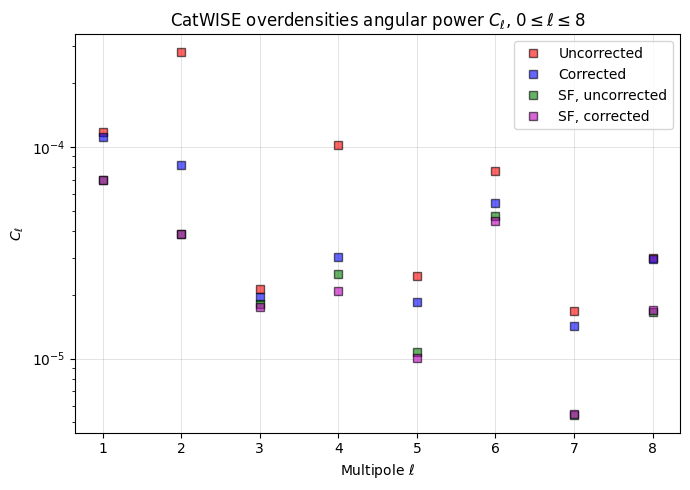

In [14]:
# plottt
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)
kwargs = dict(ls='None', mec='k', ms=6, marker='s', alpha=0.6)
ax.plot(ells[1:], Cells[1:], label='Uncorrected', c='r', **kwargs)
ax.plot(ells[1:], Cells_elat[1:], label='Corrected', c='b', **kwargs)
ax.plot(ells[1:], Cells_sf[1:], label='SF, uncorrected', c='g', **kwargs)
ax.plot(ells[1:], Cells_sf_elat[1:], label='SF, corrected', c='m', **kwargs)

ax.semilogy()
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'Multipole $\ell$')
ax.set_xticks(ells[1:])
ax.set_ylabel(r'$C_\ell$')
ax.set_title(r'CatWISE overdensities angular power $C_\ell$, $0\leq\ell\leq$'f'{max_ell}')
ax.legend()

### compare Cells with our regularization to Cells with standard / Secrest's fitting

In [15]:
# Cells with our regularization have already been computed above

In [16]:
# with standard / Secrest's fitting: we just exclude masked pixels from the fit
ells, Cells_standard = multipoles.compute_Cells_in_overdensity_map(overdensity_map,
                                                          Wmask=Wmask, max_ell=max_ell, selfunc=None,
                                                                  idx_to_fit=~np.isnan(overdensity_map)) # **
ells, Cells_standard_sf = multipoles.compute_Cells_in_overdensity_map(overdensity_map_sf,
                                                          Wmask=Wmask, max_ell=max_ell, selfunc=d.selfunc,
                                                                  idx_to_fit=~np.isnan(overdensity_map_sf)) # **

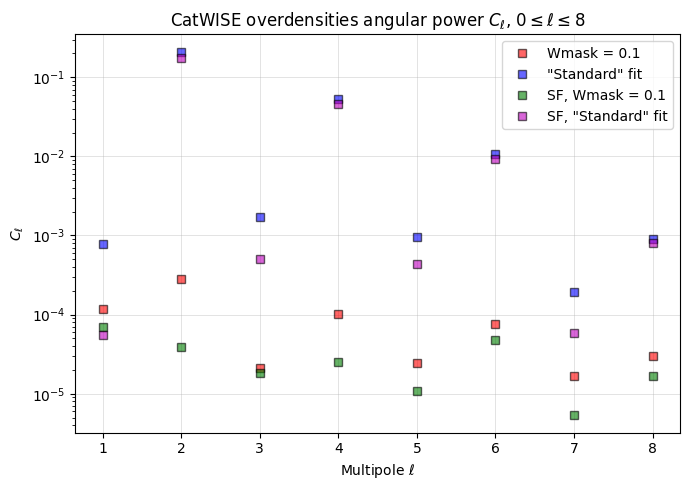

In [17]:
# plottt
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)
kwargs = dict(ls='None', mec='k', ms=6, marker='s', alpha=0.6)
ax.plot(ells[1:], Cells[1:], label='Wmask = 0.1', c='r', **kwargs)
ax.plot(ells[1:], Cells_standard[1:], label='"Standard" fit', c='b', **kwargs)
ax.plot(ells[1:], Cells_sf[1:], label='SF, Wmask = 0.1', c='g', **kwargs)
ax.plot(ells[1:], Cells_standard_sf[1:], label='SF, "Standard" fit', c='m', **kwargs)

ax.semilogy()
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'Multipole $\ell$')
ax.set_xticks(ells[1:])
ax.set_ylabel(r'$C_\ell$')
ax.set_title(r'CatWISE overdensities angular power $C_\ell$, $0\leq\ell\leq$'f'{max_ell}')
ax.legend()

## Quaia

### without / with selection function

#### $G\leq 20.0$

In [18]:
# instantiate dipole object
d = QSOSample(initial_catfn='quaia_G20.5.fits', catname='quaia', mag='G',
                    blim=30, maglim=20., load_init=True)
d.cut_galactic_plane()

# get expected dipole amplitude
expected_dipamp_quaia_low = ellisbaldwin.compute_expected_dipole_gaia(d.table, maglimit=d.maglim,
                                                            min_g=19.5, max_g=20.5)
d.cut_mag()

# and delete initial table to clear memory
del d.initial_cattab

# NO selection function
d.set_selfunc('None')

# finally, construct the overdensity map
overdensity_map = d.construct_overdensity_map()

# and measure the dipole
comps = d.measure_dipole_in_overdensity_map(overdensity_map, Wmask=Wmask)
dipole.get_dipole(comps)

loading initial catalog, quaia_G20.5.fits
1295502 sources in initial catalog.
cut |b| <= 30 -> 917566 sources left.
computing expected dipole from Ellis-Baldwin:
	number-count slope x = 1.309
	effective alpha = 0.713
	expected dipole amplitude = 0.0052
cut G > 20.0 -> 530364 sources left.
constructing overdensity map...
defining healpix mask...
	masked pixels |b|<30deg, from mask_fn, and where completeness < 0.5


(0.036939970582886034,
 <SkyCoord (ICRS): (ra, dec) in deg
     (162.32242078, -7.68455833)>)

In [19]:
# WITH selection function
d.set_selfunc(os.path.join(d.catdir, f'selfuncs/selection_function_NSIDE{d.NSIDE}_{d.mag}{d.maglim}.fits'))
overdensity_map_sf = d.construct_overdensity_map()
masked_datamap_sf = d.masked_datamap
comps_sf = d.measure_dipole_in_overdensity_map(overdensity_map_sf, Wmask=Wmask)
dipole.get_dipole(comps_sf)

constructing overdensity map...
defining healpix mask...
	masked pixels |b|<30deg, from mask_fn, and where completeness < 0.5


(0.011867024340512304,
 <SkyCoord (ICRS): (ra, dec) in deg
     (204.95691151, -27.66305145)>)

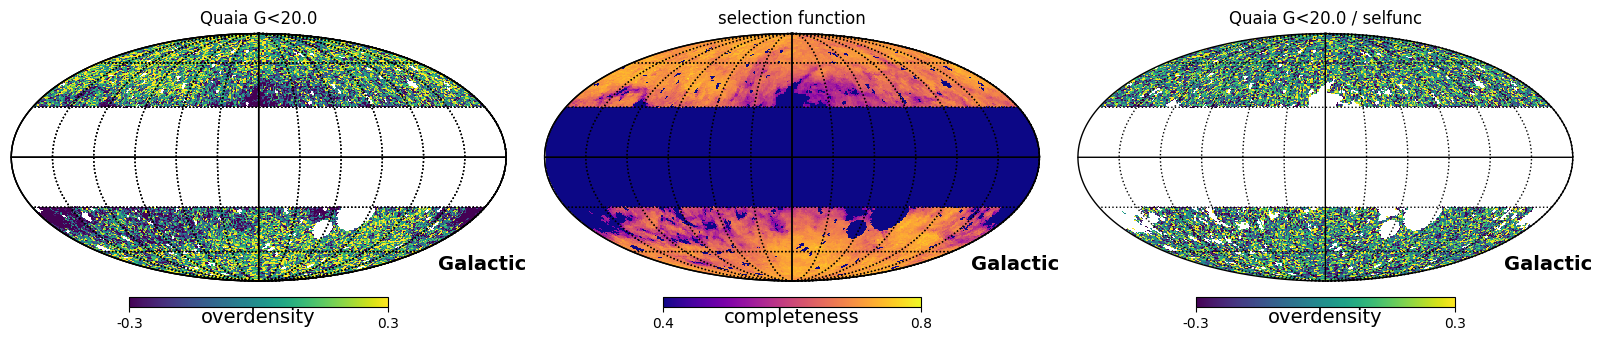

In [20]:
# plot to compare
fig = plt.figure(figsize=(16,3))
hp.mollview(overdensity_map, coord=['C','G'], min=-0.3, max=0.3, badcolor='w', fig=fig, sub=(1,3,1),
            unit='overdensity', title=f'Quaia G<{d.maglim}')
hp.graticule()
hp.mollview(d.selfunc, coord=['C','G'], min=0.4, max=0.8, badcolor='w', fig=fig, sub=(1,3,2), cmap='plasma',
            unit='completeness', title=f'selection function')
hp.graticule()
hp.mollview(overdensity_map_sf, coord=['C','G'], min=-0.3, max=0.3, badcolor='w', fig=fig, sub=(1,3,3),
            unit='overdensity', title=f'Quaia G<{d.maglim} / selfunc')
hp.graticule()

In [21]:
# Cells measurement
# max_ell defined above with CatWISE
ells, Cells = multipoles.compute_Cells_in_overdensity_map(overdensity_map,
                                                          Wmask=Wmask, max_ell=max_ell, selfunc=None)
ells, Cells_sf = multipoles.compute_Cells_in_overdensity_map(overdensity_map_sf,
                                                          Wmask=Wmask, max_ell=max_ell, selfunc=d.selfunc)

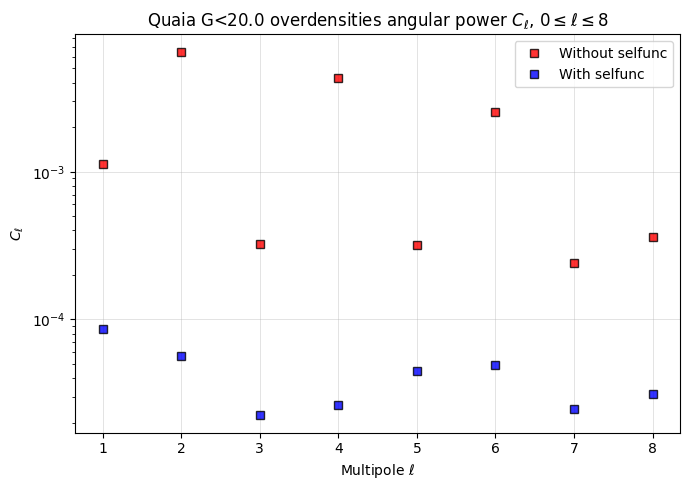

In [22]:
# plottt
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)
kwargs = dict(ls='None', mec='k', ms=6, marker='s')
ax.plot(ells[1:], Cells[1:], label='Without selfunc', c='r', alpha=0.8, **kwargs)
ax.plot(ells[1:], Cells_sf[1:], label='With selfunc', c='b', alpha=0.8, **kwargs)

ax.semilogy()
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'Multipole $\ell$')
ax.set_xticks(ells[1:])
ax.set_ylabel(r'$C_\ell$')
ax.set_title(f'Quaia G<{d.maglim} 'r'overdensities angular power $C_\ell$, $0\leq\ell\leq$'f'{max_ell}')
ax.legend()

### Quaia without / with ecliptic latitude correction

In [23]:
# ecliptic latitudes of each healpixel defined above, with CatWISE

# fit a line: density vs elat
idx = ~np.isnan(elat) & ~np.isnan(masked_datamap)
p = np.polyfit(np.abs(elat)[idx], masked_datamap[idx], deg=1)
# correct the densities and fit to the corrected densities
map_elatcorr = masked_datamap - np.polyval(p, np.abs(elat.value)) + p[1]
p_corr = np.polyfit(np.abs(elat)[idx], map_elatcorr[idx], deg=1)
# then the overdensity map is
overdensity_map_elat = map_elatcorr / np.nanmean(map_elatcorr) - 1

# same for the completeness-corrected map
idx = ~np.isnan(elat) & ~np.isnan(masked_datamap_sf)
p_sf = np.polyfit(np.abs(elat)[idx], masked_datamap_sf[idx], deg=1)
map_elatcorr_sf = masked_datamap_sf - np.polyval(p_sf, np.abs(elat.value)) + p_sf[1]
p_corr_sf = np.polyfit(np.abs(elat)[idx], map_elatcorr_sf[idx], deg=1)
# then the overdensity map is
overdensity_map_sf_elat = map_elatcorr_sf / np.nanmean(map_elatcorr_sf) - 1

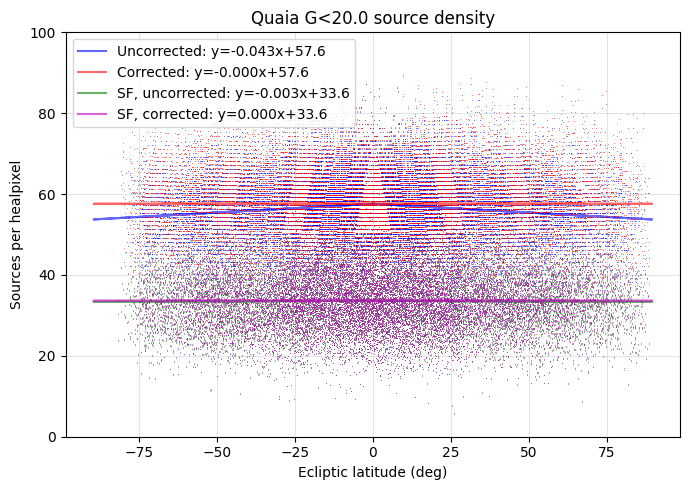

In [24]:
# plot before/after the correction
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)
# with no selection function:
# uncorrected
ax.plot(elat, masked_datamap, ls='None', marker=',', c='b', alpha=0.5)
# above the plane
ax.plot(elat[elat.value>0], elat.value[elat.value>0] * p[0] + p[1], c='b',
        alpha=0.6, label=f'Uncorrected: y={p[0]:.3f}x+{p[1]:.1f}')
# below the plane
ax.plot(elat[elat.value<0], - elat.value[elat.value<0] * p[0] + p[1], c='b', alpha=0.6)
# corrected
ax.plot(elat, map_elatcorr, ls='None', marker=',', c='r', alpha=0.5)
# above the plane
ax.plot(elat[elat.value>0], elat.value[elat.value>0] * p_corr[0] + p_corr[1], c='r',
        alpha=0.6, label=f'Corrected: y={p_corr[0]:.3f}x+{p_corr[1]:.1f}')
# below the plane
ax.plot(elat[elat.value<0], - elat.value[elat.value<0] * p_corr[0] + p_corr[1], c='r', alpha=0.6)

# with selection function:
# uncorrected
ax.plot(elat, masked_datamap_sf, ls='None', marker=',', c='g', alpha=0.5)
# above the plane
ax.plot(elat[elat.value>0], elat.value[elat.value>0] * p_sf[0] + p_sf[1], c='g',
        alpha=0.6, label=f'SF, uncorrected: y={p_sf[0]:.3f}x+{p_sf[1]:.1f}')
# below the plane
ax.plot(elat[elat.value<0], - elat.value[elat.value<0] * p_sf[0] + p_sf[1], c='g', alpha=0.6)
# corrected
ax.plot(elat, map_elatcorr_sf, ls='None', marker=',', c='m', alpha=0.5)
# above the plane
ax.plot(elat[elat.value>0], elat.value[elat.value>0] * p_corr_sf[0] + p_corr_sf[1], c='m',
        alpha=0.6, label=f'SF, corrected: y={p_corr_sf[0]:.3f}x+{p_corr_sf[1]:.1f}')
# below the plane
ax.plot(elat[elat.value<0], - elat.value[elat.value<0] * p_corr_sf[0] + p_corr_sf[1], c='m', alpha=0.6)

ax.grid(alpha=0.5, lw=0.5)
ax.set_ylim(0, 100)
ax.set_xlabel('Ecliptic latitude (deg)')
ax.set_ylabel('Sources per healpixel')
ax.set_title(f'Quaia G<{d.maglim} source density')
ax.legend()

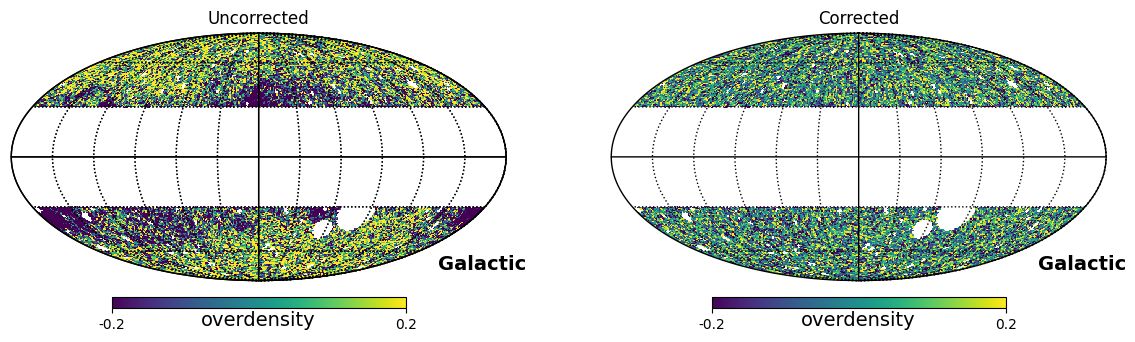

In [25]:
# check overdensity maps before and after
fig = plt.figure(figsize=(12,3))
kwargs = dict(coord=['C','G'], fig=fig, unit='overdensity', min=-.2, max=.2, badcolor='w')
hp.mollview(overdensity_map, sub=(1,2,1), title='Uncorrected', **kwargs)
hp.graticule()
hp.mollview(overdensity_map_elat, sub=(1,2,2), title='Corrected', **kwargs)
hp.graticule()

In [26]:
# measure dipole
comps_elat = d.measure_dipole_in_overdensity_map(overdensity_map_elat, Wmask=Wmask, selfunc='None')
print(dipole.get_dipole(comps_elat))
# and with selection function
comps_sf_elat = d.measure_dipole_in_overdensity_map(overdensity_map_sf_elat, Wmask=Wmask, selfunc=d.selfunc)
print(dipole.get_dipole(comps_sf_elat))

(0.013377551558305025, <SkyCoord (ICRS): (ra, dec) in deg
    (143.33249994, -5.65557859)>)
(0.011562517341179818, <SkyCoord (ICRS): (ra, dec) in deg
    (205.48575887, -26.44613496)>)


In [27]:
# measure Cells
ells, Cells_elat = multipoles.compute_Cells_in_overdensity_map(overdensity_map_elat,
                                                          Wmask=Wmask, max_ell=max_ell, selfunc=None)
# and in completeness-corrected
ells, Cells_sf_elat = multipoles.compute_Cells_in_overdensity_map(overdensity_map_sf_elat,
                                                          Wmask=Wmask, max_ell=max_ell, selfunc=d.selfunc)

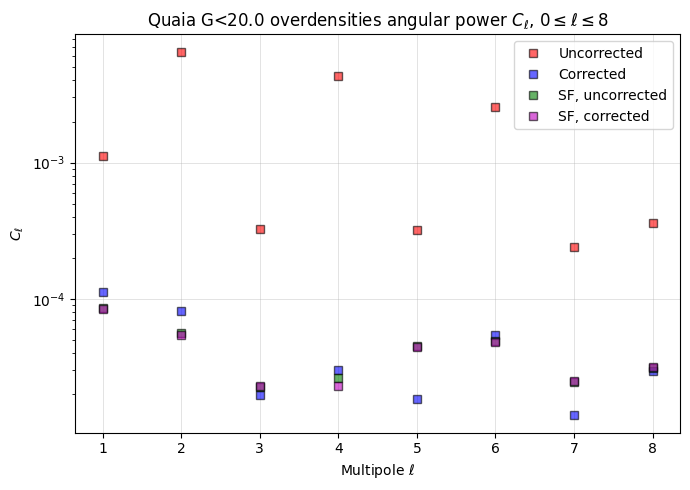

In [28]:
# plottt
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)
kwargs = dict(ls='None', mec='k', ms=6, marker='s', alpha=0.6)
ax.plot(ells[1:], Cells[1:], label='Uncorrected', c='r', **kwargs)
ax.plot(ells[1:], Cells_elat[1:], label='Corrected', c='b', **kwargs)
ax.plot(ells[1:], Cells_sf[1:], label='SF, uncorrected', c='g', **kwargs)
ax.plot(ells[1:], Cells_sf_elat[1:], label='SF, corrected', c='m', **kwargs)

ax.semilogy()
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'Multipole $\ell$')
ax.set_xticks(np.arange(1, max(ells)+1))
ax.set_ylabel(r'$C_\ell$')
ax.set_title(f'Quaia G<{d.maglim} 'r'overdensities angular power $C_\ell$, $0\leq\ell\leq$'f'{max_ell}')
ax.legend()

### compare Cells with our regularization to Cells with standard / Secrest's fitting

In [29]:
# Cells with our regularization have already been computed above

In [30]:
# with standard / Secrest's fitting: we just exclude masked pixels from the fit
ells, Cells_standard = multipoles.compute_Cells_in_overdensity_map(overdensity_map,
                                                          Wmask=Wmask, max_ell=max_ell, selfunc=None,
                                                                  idx_to_fit=~np.isnan(overdensity_map)) # **
ells, Cells_standard_sf = multipoles.compute_Cells_in_overdensity_map(overdensity_map_sf,
                                                          Wmask=Wmask, max_ell=max_ell, selfunc=d.selfunc,
                                                                  idx_to_fit=~np.isnan(overdensity_map_sf)) # **

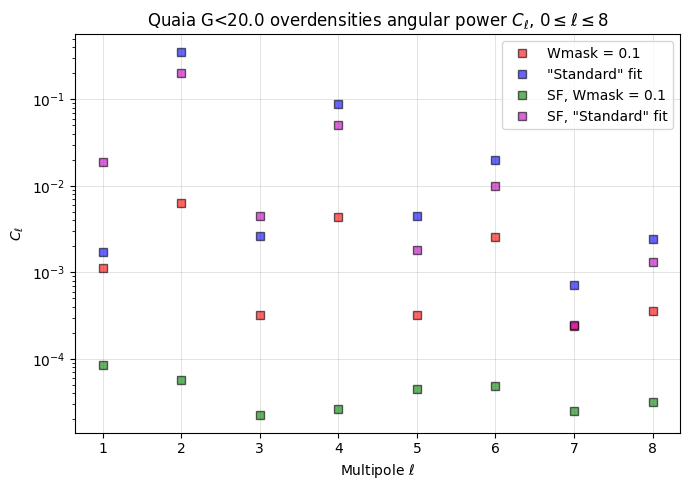

In [31]:
# plottt
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)
kwargs = dict(ls='None', mec='k', ms=6, marker='s', alpha=0.6)
ax.plot(ells[1:], Cells[1:], label='Wmask = 0.1', c='r', **kwargs)
ax.plot(ells[1:], Cells_standard[1:], label='"Standard" fit', c='b', **kwargs)
ax.plot(ells[1:], Cells_sf[1:], label='SF, Wmask = 0.1', c='g', **kwargs)
ax.plot(ells[1:], Cells_standard_sf[1:], label='SF, "Standard" fit', c='m', **kwargs)

ax.semilogy()
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'Multipole $\ell$')
ax.set_xticks(ells[1:])
ax.set_ylabel(r'$C_\ell$')
ax.set_title(f'Quaia G<{d.maglim} 'r'overdensities angular power $C_\ell$, $0\leq\ell\leq$'f'{max_ell}')
ax.legend()

### dipole amplitude as a function of regularization strength

In [32]:
# first, just the dipole:
# choose a few Wmasks / regularization strengths
Wmasks = np.logspace(-4, 4, 19)

dipole_amplitudes = np.empty_like(Wmasks)
for i, Wmask_ in enumerate(Wmasks):
    
    # compute the Cells on the completeness-corrected Quaia
    ells_, Cells = multipoles.compute_Cells_in_overdensity_map(overdensity_map_sf,
                                                              Wmask=Wmask_, max_ell=1, selfunc=d.selfunc)
    # store the dipole amplitude
    dipole_amplitudes[i] = Cells[1]

[]

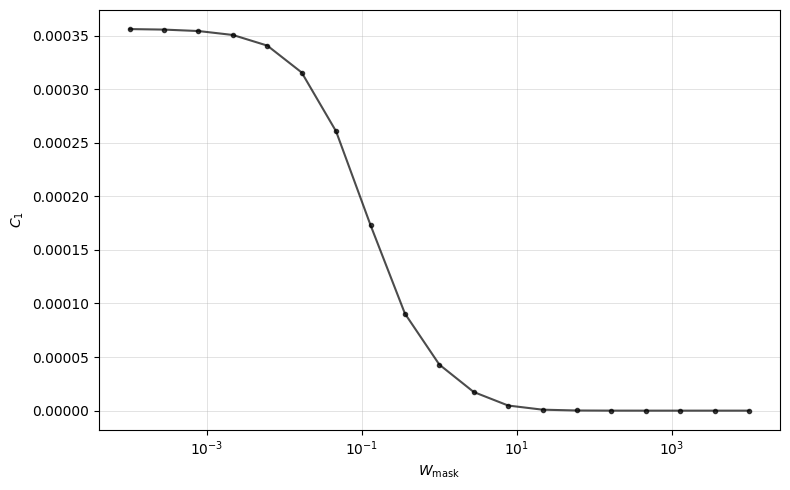

In [34]:
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)

ax.plot(Wmasks, dipole_amplitudes, c='k', alpha=0.7, marker='.')

# ax.axhline(expected_dipamp_quaia_low, c='k', alpha=0.5, label='Expected from CMB')
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'$W_\mathrm{mask}$')
ax.set_ylabel(r'$C_1$')
ax.semilogx()

In [38]:
# choose a few max ells
max_ells = np.arange(1,6).astype(int)

# and Wmasks / regularization strengths
Wmasks = np.logspace(-4,4,11)

dipole_amplitudes = np.empty((len(max_ells), len(Wmasks)))
for i, max_ell_ in enumerate(max_ells):
    
    for j, Wmask_ in enumerate(Wmasks):
        
        print(f"max_ell = {max_ell_}, Wmask = {Wmask_}", end='\r')
    
        # compute the Cells on the completeness-corrected Quaia
        ells_, Cells = multipoles.compute_Cells_in_overdensity_map(overdensity_map_sf,
                                                              Wmask=Wmask_, max_ell=max_ell_, selfunc=d.selfunc)
        # store the dipole amplitude
        dipole_amplitudes[i,j] = Cells[1]

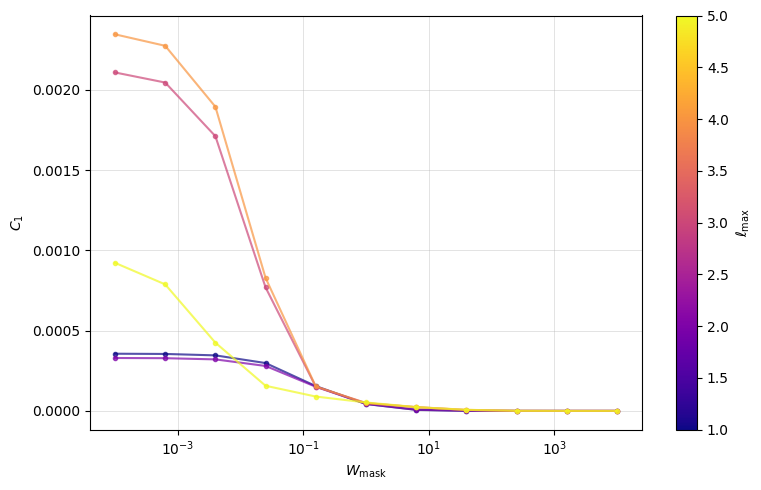

In [40]:
norm = mpl.colors.Normalize(vmin=min(max_ells), vmax=max(max_ells))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='plasma')

fig, ax = plt.subplots(figsize=(8,5), tight_layout=True)

for i, max_ell_ in enumerate(max_ells):
    ax.plot(Wmasks, dipole_amplitudes[i], c=smap.to_rgba(max_ell_), alpha=0.7, marker='.')

# ax.axhline(expected_dipamp_quaia_low, c='k', alpha=0.5, label='Expected from CMB')
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'$W_\mathrm{mask}$')
ax.set_ylabel(r'$C_1$')
ax.semilogx()
fig.colorbar(smap, ax=ax, label=r'$\ell_\mathrm{max}$')